In [1]:
from hamiltonian import HamiltonianSmall, Hamiltonian

In [2]:
lih_small = HamiltonianSmall('LiH', 1.5) # this encoding uses reduction techniques
beh2_small = HamiltonianSmall('BeH2', 1.3) # this encoding uses reduction techniques

# 4 qubits
h2_jw_4 = Hamiltonian('H2_STO3g_4qubits', 'jw')
h2_parity_4 = Hamiltonian('H2_STO3g_4qubits', 'parity')
h2_bk_4 = Hamiltonian('H2_STO3g_4qubits', 'bk')

# 8 qubits
h2_jw = Hamiltonian('H2_6-31G_8qubits', 'jw')
h2_parity = Hamiltonian('H2_6-31G_8qubits', 'parity')
h2_bk = Hamiltonian('H2_6-31G_8qubits', 'bk')

# 12 qubits
lih_jw = Hamiltonian('LiH_STO3g_12qubits', 'jw')
lih_parity = Hamiltonian('LiH_STO3g_12qubits', 'parity')
lih_bk = Hamiltonian('LiH_STO3g_12qubits', 'bk')

# 14 qubits
beh2_jw = Hamiltonian('BeH2_STO3g_14qubits', 'jw')
beh2_parity = Hamiltonian('BeH2_STO3g_14qubits', 'parity')
beh2_bk = Hamiltonian('BeH2_STO3g_14qubits', 'bk')

h2o_jw = Hamiltonian('H2O_STO3g_14qubits', 'jw')
h2o_parity = Hamiltonian('H2O_STO3g_14qubits', 'parity')
h2o_bk = Hamiltonian('H2O_STO3g_14qubits', 'bk')

# 16 qubits
nh3_jw = Hamiltonian('NH3_STO3g_16qubits', 'jw')
nh3_parity = Hamiltonian('NH3_STO3g_16qubits', 'parity')
nh3_bk = Hamiltonian('NH3_STO3g_16qubits', 'bk')

# 20 qubits
c2_jw = Hamiltonian('C2_STO3g_20qubits', 'jw')
c2_parity = Hamiltonian('C2_STO3g_20qubits', 'parity')
c2_bk = Hamiltonian('C2_STO3g_20qubits', 'bk')

hcl_jw = Hamiltonian('HCl_STO3g_20qubits', 'jw')
hcl_parity = Hamiltonian('HCl_STO3g_20qubits', 'parity')
hcl_bk = Hamiltonian('HCl_STO3g_20qubits', 'bk')

In [3]:
hamiltonians = {"h2_jw_4": h2_jw_4,
                "h2_jw": h2_jw,
                "lih_jw": lih_jw,
                "beh2_jw": beh2_jw,
                "h2o_jw": h2o_jw}

# Variance formula

\begin{equation}\label{eq:var_pauli_biased}
	\Var(\nu) = \left(\sum_{Q,R} f(Q,R,\beta) \alpha_Q \alpha_R \tr(\rho Q R)\right) - \left(\tr(\rho O) \right)^2.
\end{equation}

# Variance optimisation (method=diagonal)

This is not the correct optimisation. However it
- gives good results;
- is quicker than the full optimisation problem;
- is convex (so local minimums are global);
- does not need access to the Hartree-Fock bitstring for the encoding.

Diagonal minimisation asks us to find $\{\beta_{i,P}\}$ in order to minimise:
$$\label{eq:cost_diag}
    \mathrm{cost}_\mathrm{diag}(\beta)
    =
    \sum_Q \alpha_Q^2 \prod_{i\in\supp(Q)} (\beta_i(Q_i))^{-1}
    \textrm{subject to}
    \qquad
    \beta_{i,X}+\beta_{i,Y}+\beta_{i,Z}=1 \,\forall i,
    \qquad
    \beta_{i,P}\ge 0
$$

And we have an implementation using Lagrange multipliers

# Variance optimisation (method=mixed)

This is the full optimisation problem. It requires access to the Hartree-Fock bitstring $m$ or `bitstring_HF` so that the HF state reads
$\frac1{2^n}\otimes_{i=1}^n (I+m_i Z)$

In the JW encoding these are:
- H2 = `1010` (on four qubits)
- H2 = `10001000`
- LiH = `100000100000`
- H2O = `11111001111100`
- BeH2 = `11100001110000`
- NH3 = `1111100011111000`
You can retrieve them by calling `Hamiltonian.read_bitstring_HF()`

Consider the set of influential pairs:
\begin{align}
    \mathcal{I}_{Z^{\otimes n}}
    =
    \left\{\left.
        (Q,R)
        \,\right|\,
        \textrm{$Q,R\neq I^{\otimes n}$ and for all $i$, either $Q_i=R_i$, or $\{Q_i,R_i\}=\{I,Z\}$}
    \right\}
\end{align}

Then the cost function to optimise will be:
\begin{align}\label{eq:cost}
    \mathrm{cost}(\beta)
    =
    \sum_{(Q,R)\in\mathcal{I}_{Z^{\otimes n}}}
        \alpha_Q
        \alpha_R
        \prod_{i | Q_i=R_i\neq I}
            (\beta_i(Q_i))^{-1}
        \prod_{i | Q_i\neq R_i}
            m_i
\end{align}

Warning, the small Hamiltonians don't follow the pattern because they use other reduction techniques

# Benchmarking

In [4]:
def variances_dict(ham, β_diag=None, β_mix=None):
    pr = ham.pauli_rep
    dic = {}
    
    energy, state = pr.ground(multithread=False)
    print("energy :", energy)

    # optimal (diagonal)
    if β_diag is not None:
        var = pr.variance_local(energy, state, β_diag, multithread=False)
        print("optimal diagonal: ", var)
        dic['optimal_diag'] = var
 
    # optimal (mixed)
    if β_mix is not None:
        var = pr.variance_local(energy, state, β_mix, multithread=False)
        print("optimal mixed: ", var)
        dic['optimal_mix'] = var
    
    return dic

from matplotlib import pyplot as plt

def variances_graph(variances):
    num_variances = len(variances)
    x = range(num_variances)
    height = list(variances.values())

    plt.bar(x, height)
    plt.xticks(x, list(variances.keys()), rotation=20)
    plt.title(title)

    plt.show()

In [5]:
variances_ALL = {}
beta_optimal_ALL = {}

In [6]:
import time
import numpy as np

In [7]:
def benchmarking(name, ham, title):
    bitstring_HF = ham.read_bitstring_HF()
    
    t0 = time.time()
    β_diag = ham.pauli_rep.local_dists_optimal('diagonal', 'lagrange')
    t1 = time.time()
    print("β_diag found. Time taken: {} seconds".format(t1-t0))
    β_mix = ham.pauli_rep.local_dists_optimal('mixed', 'lagrange', β_initial=β_diag, bitstring_HF=bitstring_HF)
    t2 = time.time()
    print("β_mix found.  Time taken: {} seconds".format(t2-t1))
    beta_optimal_ALL[name] = {'diagonal': β_diag, 'mixed': β_mix}
    
    variances_ALL[name] = variances_dict(ham, β_diag=β_diag, β_mix=β_mix)
    t3 = time.time()
    print("Variances calculated.  Time taken: {} seconds".format(t3-t2))
    
    print("=====")
    print(title)
    print("=====")
    print(variances_ALL[name])
    print("=====")
    
    variances_graph(variances_ALL[name])  

In [8]:
def distributions_plot(name, cost='diagonal'):
    β = beta_optimal_ALL[name][cost]
    
    qubits = range(len(β)//2)

    X = [β[i][0] for i in qubits]
    Y = [β[i][1] for i in qubits]
    Z = [β[i][2] for i in qubits]

    x = np.arange(len(qubits))
    width = 0.75

    fig = plt.gcf()
    fig.set_size_inches(10,6)
    
    pX = plt.bar(x, X, width, color='r')
    pY = plt.bar(x, Y, width, bottom=X, color='b')
    pZ = plt.bar(x, Z, width, bottom=[x+y for x,y in zip(X, Y)], color='g')
    
    plt.show()

β_diag found. Time taken: 0.009313106536865234 seconds
β_mix found.  Time taken: 0.01495814323425293 seconds
energy : -1.8572750302023768
optimal diagonal:  1.8555830498849541
optimal mixed:  1.8546562200043262
Variances calculated.  Time taken: 0.025011777877807617 seconds
=====
Variances for various algorithms on H2 in JW encoding over 4 qubits
=====
{'optimal_diag': 1.8555830498849541, 'optimal_mix': 1.8546562200043262}
=====


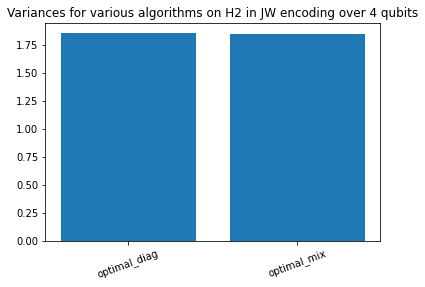

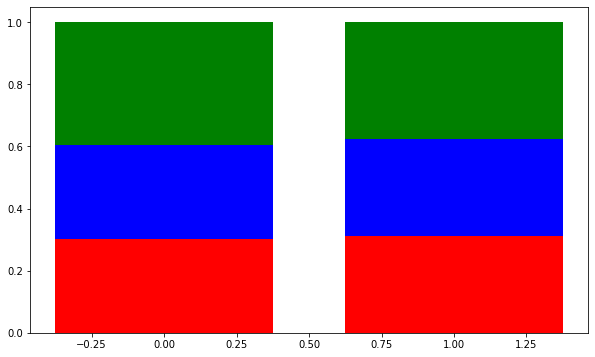

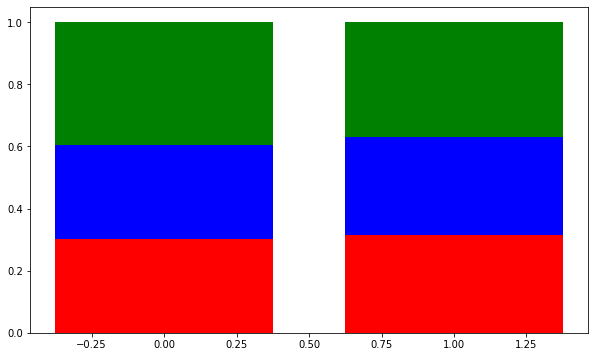

In [9]:
name = 'h2_jw_4'
ham = h2_jw_4
title = "Variances for various algorithms on H2 in JW encoding over 4 qubits"

benchmarking(name, ham, title)
distributions_plot(name)
distributions_plot(name, 'mixed')

β_diag found. Time taken: 0.1612389087677002 seconds
β_mix found.  Time taken: 0.5392389297485352 seconds
energy : -1.8608605555207556
optimal diagonal:  17.741947811137194
optimal mixed:  17.45718728202786
Variances calculated.  Time taken: 1.811075210571289 seconds
=====
Variances for various algorithms on H2 in JW encoding over 8 qubits
=====
{'optimal_diag': 17.741947811137194, 'optimal_mix': 17.45718728202786}
=====


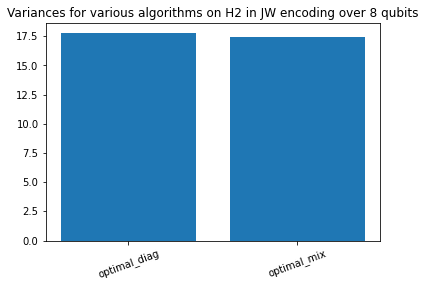

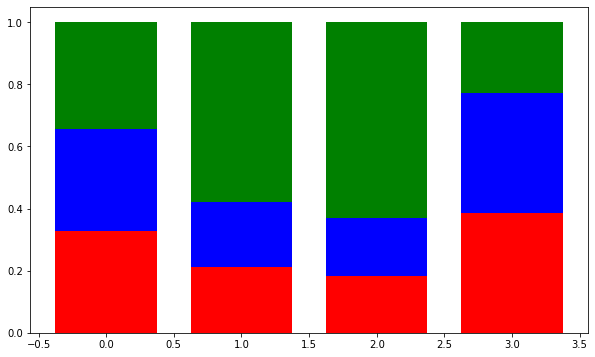

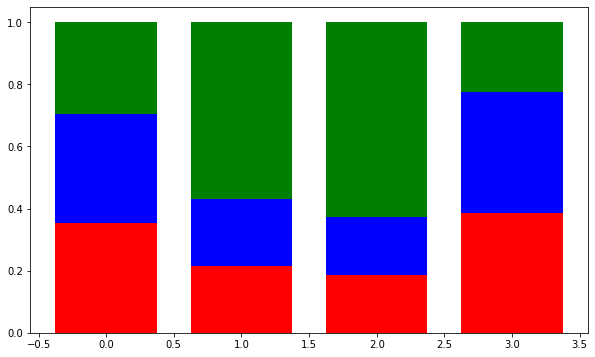

In [10]:
name = 'h2_jw'
ham = h2_jw
title = "Variances for various algorithms on H2 in JW encoding over 8 qubits"

benchmarking(name, ham, title)
distributions_plot(name)
distributions_plot(name, 'mixed')

β_diag found. Time taken: 1.199991226196289 seconds
β_mix found.  Time taken: 5.722743988037109 seconds
energy : -8.908299431473598
optimal diagonal:  14.792751908499723
optimal mixed:  14.877408442706946
Variances calculated.  Time taken: 45.63582491874695 seconds
=====
Variances for various algorithms on LiH in JW encoding over 12 qubits
=====
{'optimal_diag': 14.792751908499723, 'optimal_mix': 14.877408442706946}
=====


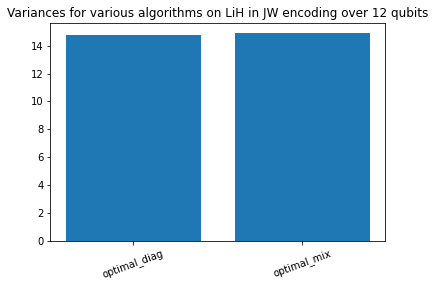

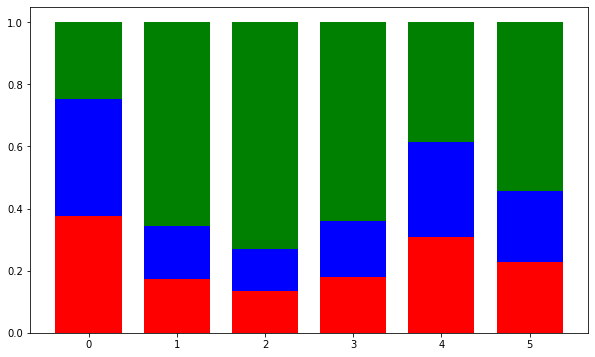

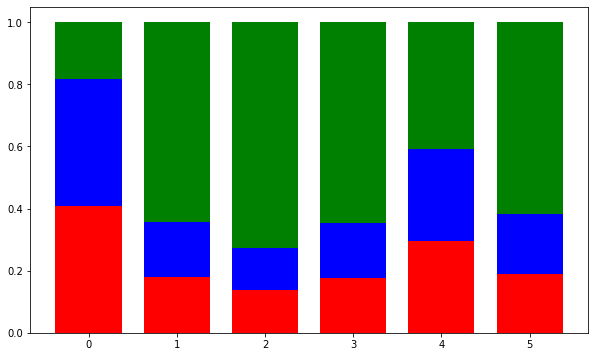

In [11]:
name = 'lih_jw'
ham = lih_jw
title = "Variances for various algorithms on LiH in JW encoding over 12 qubits"

benchmarking(name, ham, title)
distributions_plot(name)
distributions_plot(name, 'mixed')

β_diag found. Time taken: 1.5029101371765137 seconds
β_mix found.  Time taken: 5.2429869174957275 seconds
energy : -19.045049602808014
optimal diagonal:  67.59976246292398
optimal mixed:  67.48962561755701
Variances calculated.  Time taken: 156.61560225486755 seconds
=====
Variances for various algorithms on BeH2 in JW encoding over 14 qubits
=====
{'optimal_diag': 67.59976246292398, 'optimal_mix': 67.48962561755701}
=====


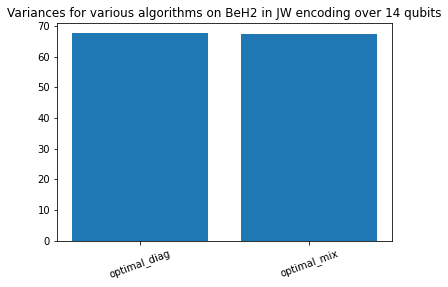

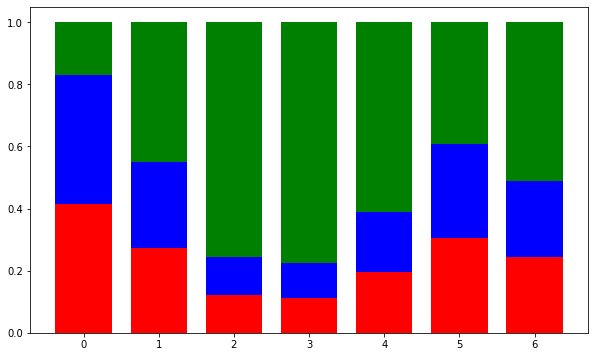

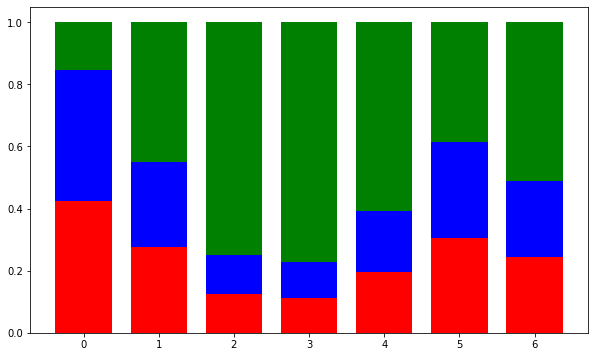

In [12]:
name = 'beh2_jw'
ham = beh2_jw
title = "Variances for various algorithms on BeH2 in JW encoding over 14 qubits"

benchmarking(name, ham, title)
distributions_plot(name)
distributions_plot(name, 'mixed')

β_diag found. Time taken: 2.8507068157196045 seconds
β_mix found.  Time taken: 9.816960096359253 seconds
energy : -83.59943020533802
optimal diagonal:  257.5439313166106
optimal mixed:  254.14106500610853
Variances calculated.  Time taken: 382.6919460296631 seconds
=====
Variances for various algorithms on H2O in JW encoding over 14 qubits
=====
{'optimal_diag': 257.5439313166106, 'optimal_mix': 254.14106500610853}
=====


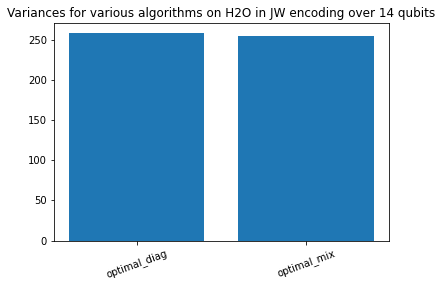

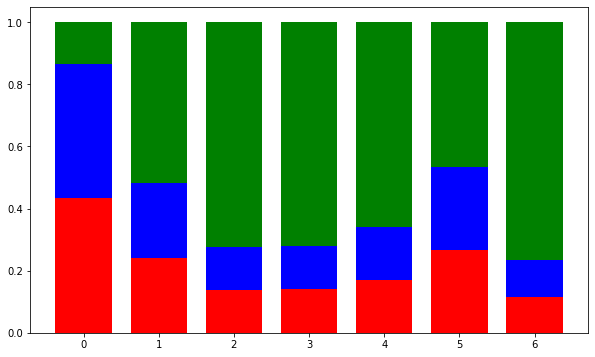

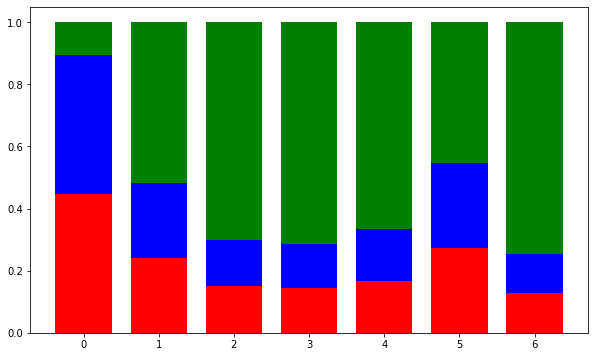

In [13]:
name = 'h2o_jw'
ham = h2o_jw
title = "Variances for various algorithms on H2O in JW encoding over 14 qubits"

benchmarking(name, ham, title)
distributions_plot(name)
distributions_plot(name, 'mixed')

In [37]:
β = beta_optimal_ALL['h2o_jw']['diagonal']

result = []
for i in range(7):
    result.append((β[i][2], 7-i))

result

[(0.13484824827695654, 7),
 (0.5180318787340902, 6),
 (0.7225848449516744, 5),
 (0.7208398751715843, 4),
 (0.6602921043880026, 3),
 (0.4649403034130343, 2),
 (0.7670439840911827, 1)]

# Bravyi-Kitaev encoding

In [14]:
def benchmarking_BK(name, ham, title):    
    t0 = time.time()
    β_diag = ham.pauli_rep.local_dists_optimal('diagonal', 'lagrange')
    t1 = time.time()
    print("β_diag found. Time taken: {} seconds".format(t1-t0))
    beta_optimal_ALL[name] = {'diagonal': β_diag}
    
    variances_ALL[name] = variances_dict(ham, β_diag=β_diag)
    t3 = time.time()
    print("Variances calculated.  Time taken: {} seconds".format(t3-t1))
    
    print("=====")
    print(title)
    print("=====")
    print(variances_ALL[name])
    print("=====")
    
    variances_graph(variances_ALL[name])  

β_diag found. Time taken: 0.022685766220092773 seconds
energy : -1.8572750302023802
optimal diagonal:  0.5411274575466254
Variances calculated.  Time taken: 0.0240781307220459 seconds
=====
Variances for various algorithms on H2 in BK encoding over 4 qubits
=====
{'optimal_diag': 0.5411274575466254}
=====


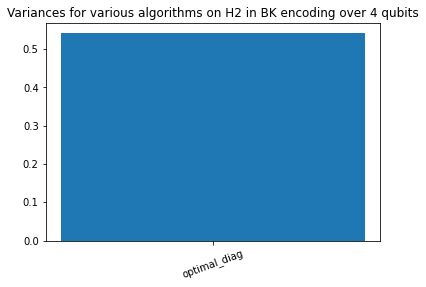

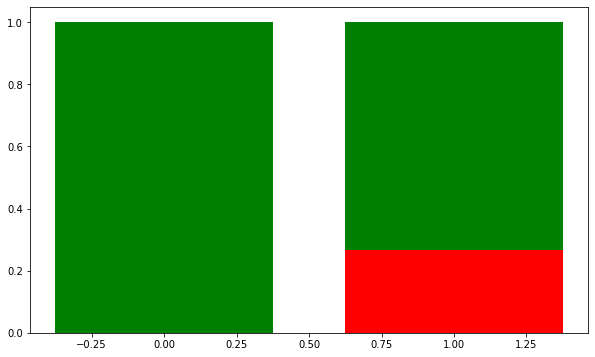

In [15]:
name = 'h2_bk_4'
ham = h2_bk_4
title = "Variances for various algorithms on H2 in BK encoding over 4 qubits"

benchmarking_BK(name, ham, title)
distributions_plot(name)

β_diag found. Time taken: 0.288438081741333 seconds
energy : -1.8608605555207627
optimal diagonal:  19.51776142096129
Variances calculated.  Time taken: 0.9912068843841553 seconds
=====
Variances for various algorithms on H2 in BK encoding over 4 qubits
=====
{'optimal_diag': 19.51776142096129}
=====


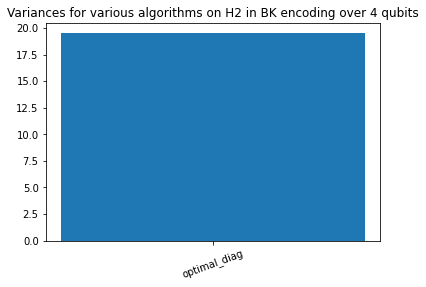

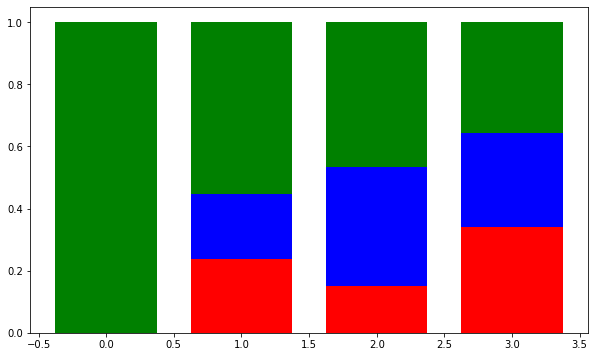

In [16]:
name = 'h2_bk'
ham = h2_bk
title = "Variances for various algorithms on H2 in BK encoding over 4 qubits"

benchmarking_BK(name, ham, title)
distributions_plot(name)

β_diag found. Time taken: 1.6469080448150635 seconds
energy : -8.908299431473603
optimal diagonal:  67.9997570296748
Variances calculated.  Time taken: 20.139108896255493 seconds
=====
Variances for various algorithms on H2 in BK encoding over 4 qubits
=====
{'optimal_diag': 67.9997570296748}
=====


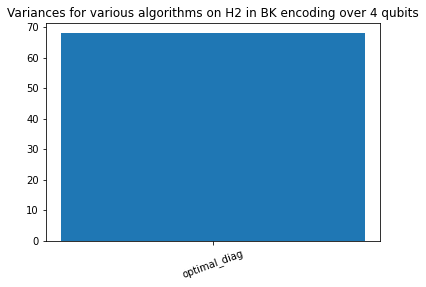

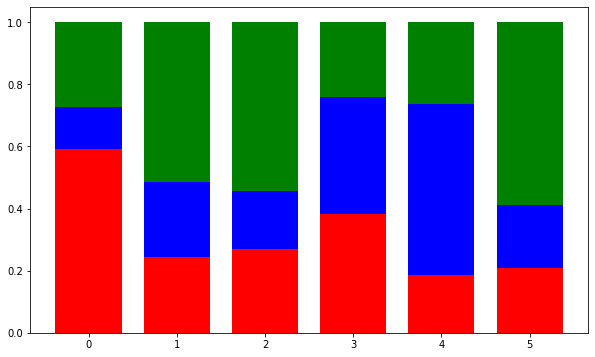

In [17]:
name = 'lih_bk'
ham = lih_bk
title = "Variances for various algorithms on H2 in BK encoding over 4 qubits"

benchmarking_BK(name, ham, title)
distributions_plot(name)

β_diag found. Time taken: 1.923326015472412 seconds
energy : -19.045049602808014
optimal diagonal:  238.33974524722055
Variances calculated.  Time taken: 68.57920694351196 seconds
=====
Variances for various algorithms on H2 in BK encoding over 4 qubits
=====
{'optimal_diag': 238.33974524722055}
=====


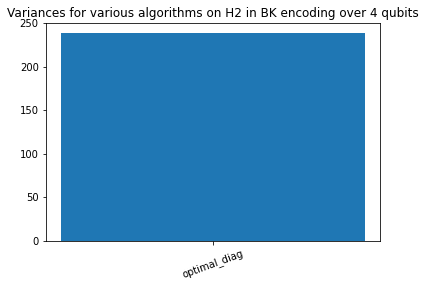

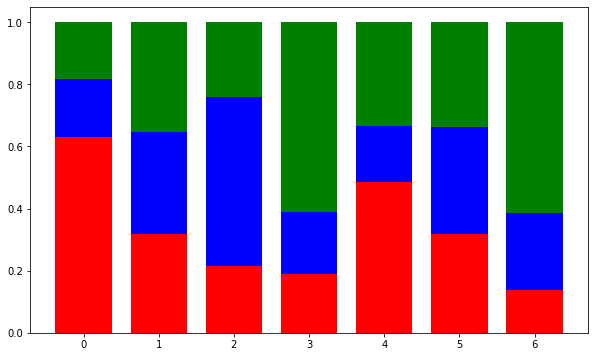

In [18]:
name = 'beh2_bk'
ham = beh2_bk
title = "Variances for various algorithms on H2 in BK encoding over 4 qubits"

benchmarking_BK(name, ham, title)
distributions_plot(name)

β_diag found. Time taken: 3.5900826454162598 seconds
energy : -83.59943020533811
optimal diagonal:  1360.1775699023656
Variances calculated.  Time taken: 168.83222913742065 seconds
=====
Variances for various algorithms on H2 in BK encoding over 4 qubits
=====
{'optimal_diag': 1360.1775699023656}
=====


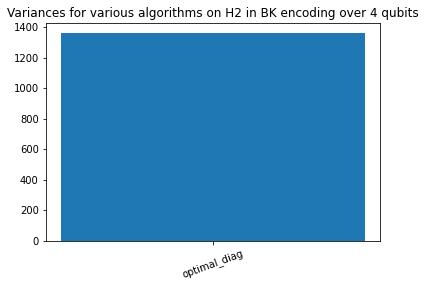

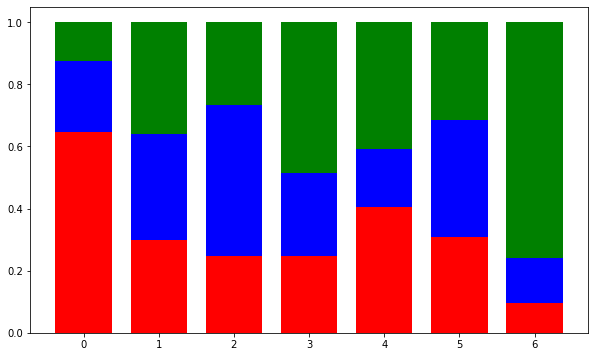

In [19]:
name = 'h2o_bk'
ham = h2o_bk
title = "Variances for various algorithms on H2 in BK encoding over 4 qubits"

benchmarking_BK(name, ham, title)
distributions_plot(name)